In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 10.9 MB/s 
     |████████████████████████████████| 80 kB 7.9 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 149 kB 46.2 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 44.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=0c954bc9994304434e7ae2c241915746827e6223adcd60d1689113a838f087c7
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from scipy import stats
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, cross_validate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df=pd.read_csv("/content/drive/MyDrive/Amex_data/Training Data_2021.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Amex_data/Test Data_2021.csv")
train_df = train_df.replace(["missing",'na'],np.nan)
test_df = test_df.replace(["missing",'na'],np.nan)

train_df['mvar47'] = train_df['mvar47'].replace('C',0).replace('L',1)
test_df['mvar47'] = test_df['mvar47'].replace('C',0).replace('L',1)

train_df=train_df.astype('float')
test_df=test_df.astype('float')

train_df = train_df.drop(['application_key'],axis=1)
test_df_copy = test_df.drop(['application_key'],axis=1)

<AxesSubplot:>

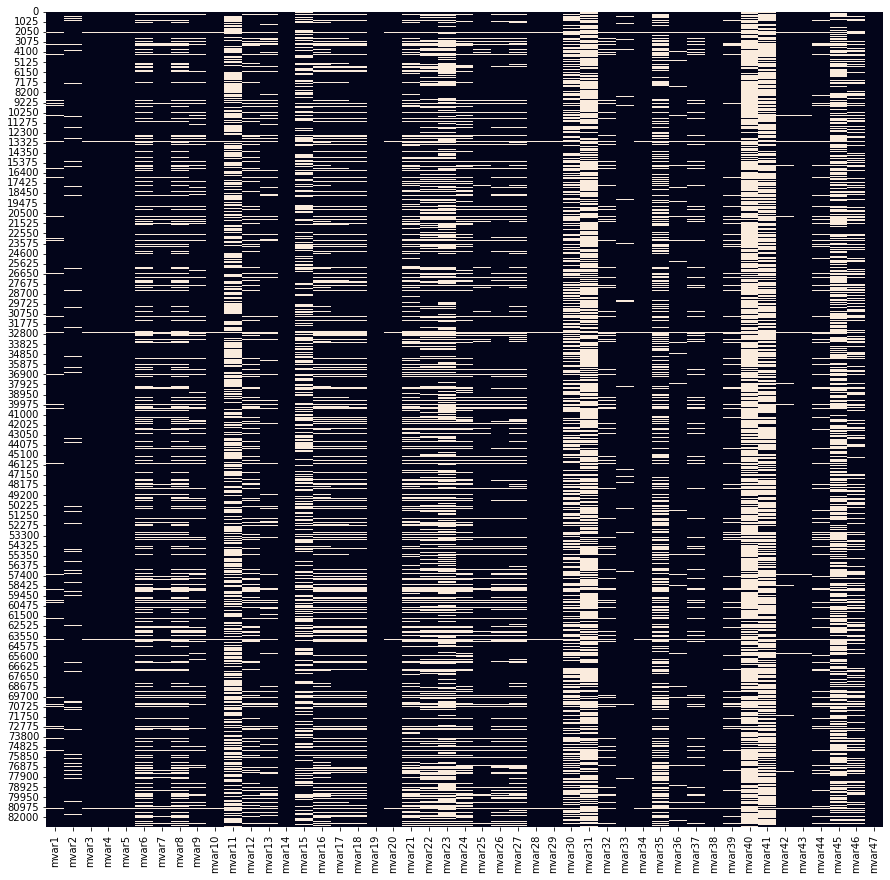

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(X_train.isnull(), cbar=False)

<AxesSubplot:>

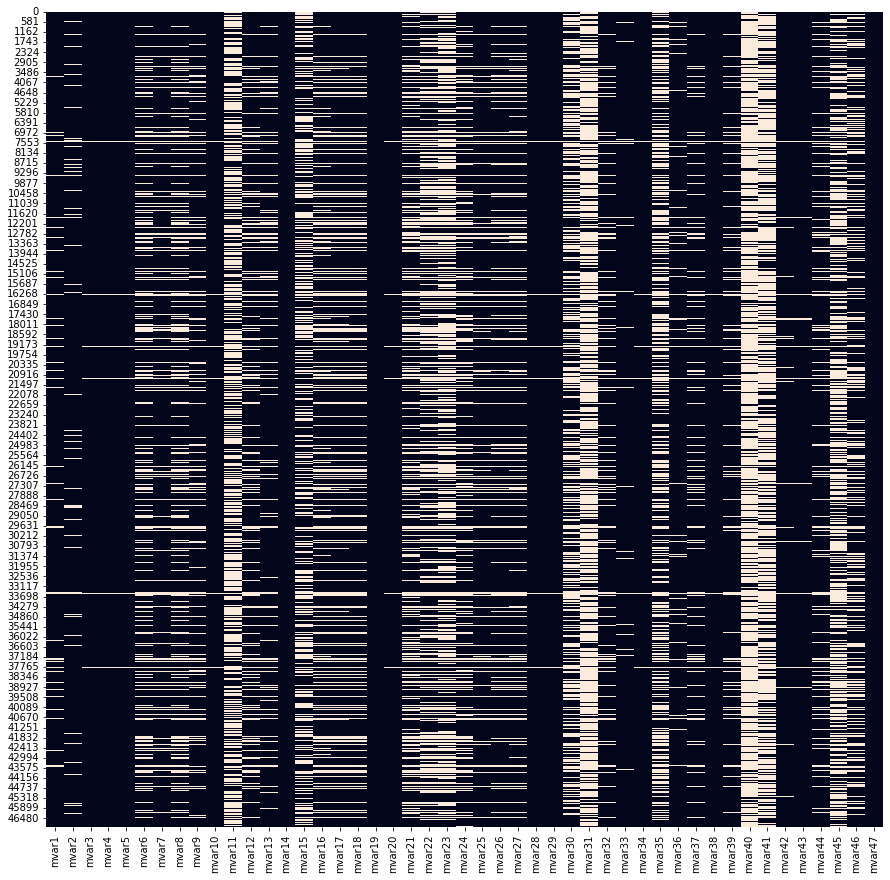

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(test_df_copy.isnull(), cbar=False)

In [ ]:
def rows_with_nan(df,thershold):
    res = []
    for s in df.index:
        if df.loc[[s]].isna().sum().sum() >=thershold:
            res.append(s)

    return res

train_nan_rows = rows_with_nan(train_df,40)
#test_nan_rows = rows_with_nan(test_df_copy,40)

In [ ]:
train_df = train_df.drop(train_nan_rows,axis=0)

X_train = train_df.iloc[:,train_df.columns!='default_ind']
Y_train = train_df['default_ind']


In [ ]:
#cat doubt: mvar28
#Cat_feat = ['mvar16','mvar17','mvar18','mvar19','mvar20','mvar28','mvar34','mvar35','mvar36','mvar37','mvar38','mvar39','mvar43','mvar45','mvar46','mvar47']
cols = list(X_train.columns)
cols.remove('mvar47')
cols.remove('mvar5')

In [ ]:
X_train = X_train.drop('mvar5',axis=1)
test_df_copy = test_df_copy.drop('mvar5',axis=1)

In [ ]:
#filling missing values for 'mvar21','mvar22','mvar23','mvar24','mvar25','mvar26'
#filling with mean/median
#filling with knn
#filling with mean
for i in cols:
    X_train[i] = X_train[i].fillna(value=X_train[i].mean())
for i in cols:
    test_df_copy[i] = test_df_copy[i].fillna(value=test_df_copy[i].mean())

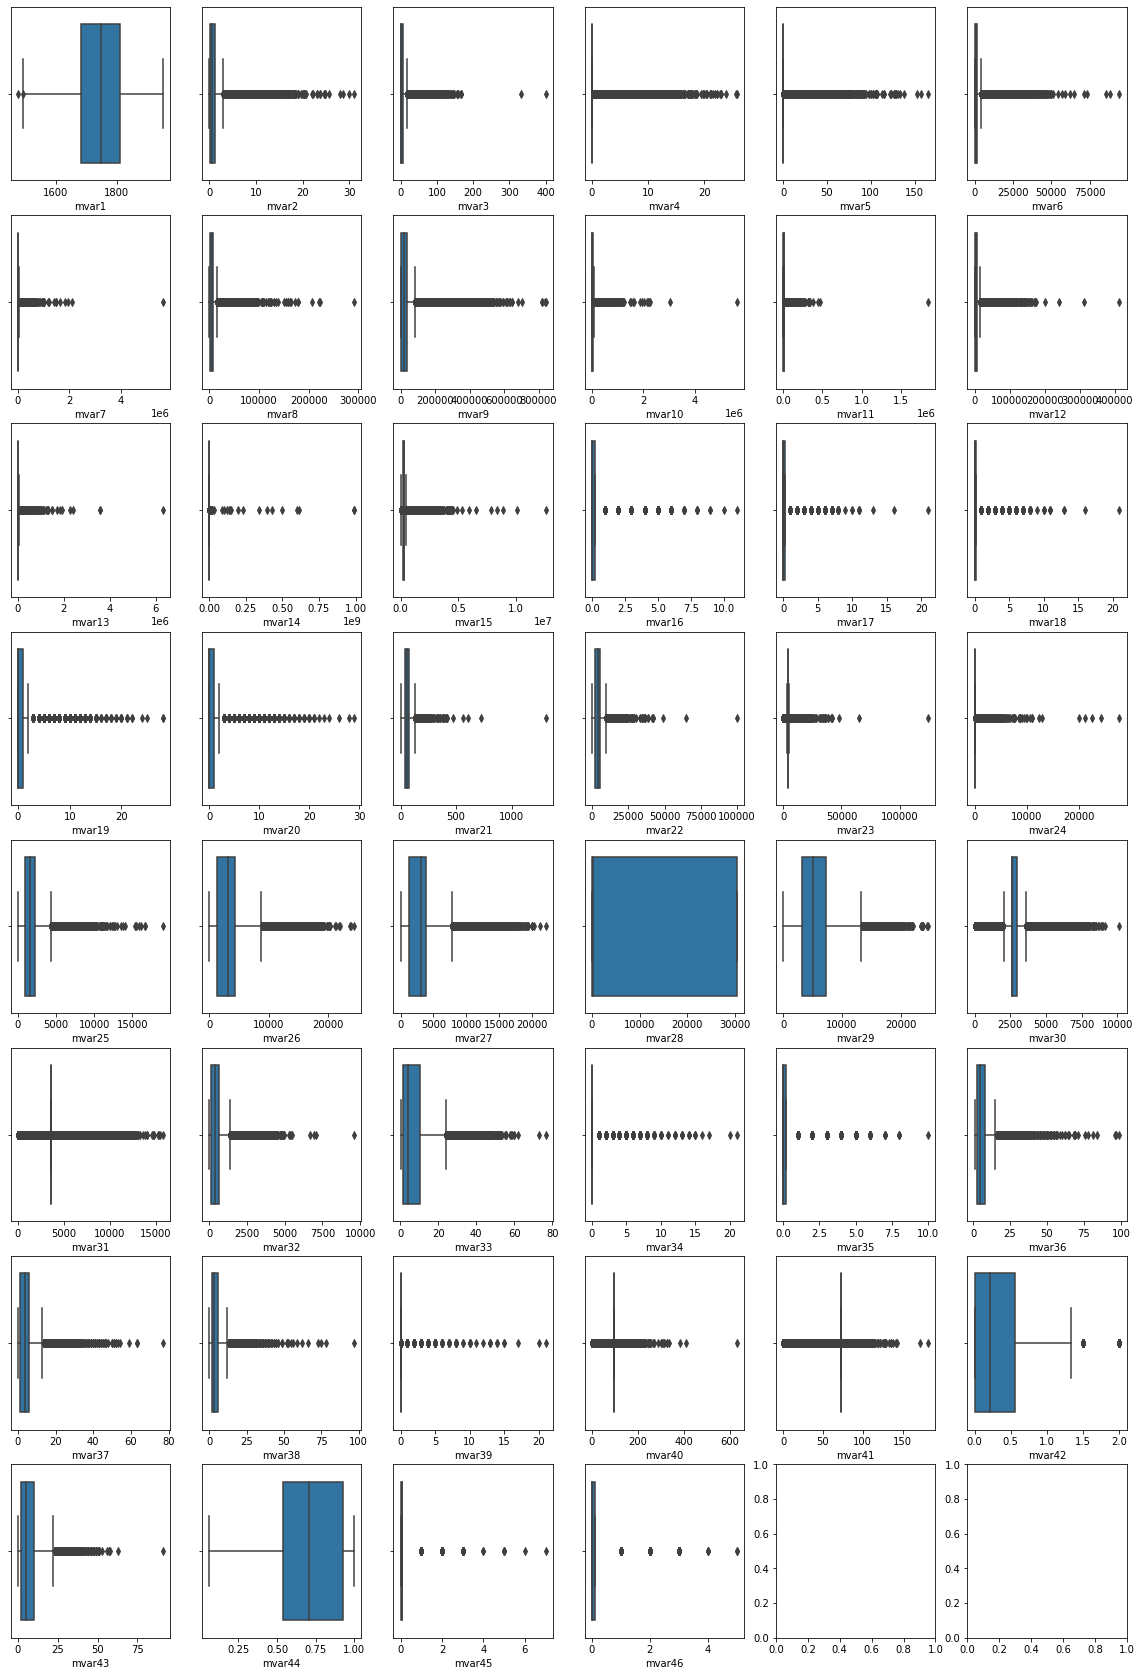

In [ ]:
fig,axes = plt.subplots(8,6,figsize=(20,30))
j = 0
k=0
for i in cols:
    sns.boxplot(X_train[i],ax=axes[k,j])
    j+=1
    if j==6:
        k+=1
        j=0

In [ ]:
#replace outliners with upper and lower value
for i in cols :
    q1 = np.nanpercentile(X_train[i], 25)
    q3 = np.nanpercentile(X_train[i], 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    tenth_per = np.nanpercentile(X_train[i], 10)
    ninty_per = np.nanpercentile(X_train[i], 90)

    X_train[i] = np.where(
        X_train[i] > upr_bound,
        ninty_per,
        np.where(
            X_train[i] < lwr_bound,
            tenth_per,
            X_train[i]
        )
    )

In [ ]:
for i in cols :
    q1 = np.nanpercentile(test_df_copy[i], 25)
    q3 = np.nanpercentile(test_df_copy[i], 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    tenth_per = np.nanpercentile(test_df_copy[i], 10)
    ninty_per = np.nanpercentile(test_df_copy[i], 90)

    test_df_copy[i] = np.where(
        test_df_copy[i] > upr_bound,
        ninty_per,
        np.where(
            test_df_copy[i] < lwr_bound,
            tenth_per,
            test_df_copy[i]
        )
    )

In [ ]:
cor_matrix_train=X_train.corr().abs()
upper_tri_train = cor_matrix_train.where(np.triu(np.ones(cor_matrix_train.shape),k=1).astype(np.bool))

In [ ]:
cor_matrix_test=test_df_copy.corr().abs()
upper_tri_test = cor_matrix_test.where(np.triu(np.ones(cor_matrix_test.shape),k=1).astype(np.bool))

In [ ]:
to_drop = [column for column in upper_tri_train.columns if any(upper_tri_train[column] > 0.7)]
print(to_drop)

['mvar10', 'mvar17', 'mvar18', 'mvar20', 'mvar23', 'mvar26', 'mvar27', 'mvar32', 'mvar37', 'mvar42']


In [ ]:
to_drop = [column for column in upper_tri_test.columns if any(upper_tri_test[column] > 0.7)]
print(to_drop)

['mvar10', 'mvar17', 'mvar18', 'mvar20', 'mvar23', 'mvar26', 'mvar27', 'mvar32', 'mvar37', 'mvar42']


In [ ]:
s = cor_matrix.unstack()
so = s.sort_values(kind="quicksort")

In [ ]:
so[-70:-47]

mvar25  mvar27    0.726953
mvar42  mvar1     0.732408
mvar1   mvar42    0.732408
mvar32  mvar9     0.733052
mvar9   mvar32    0.733052
mvar23  mvar22    0.776920
mvar22  mvar23    0.776920
mvar32  mvar37    0.825541
mvar37  mvar32    0.825541
mvar10  mvar7     0.846622
mvar7   mvar10    0.846622
mvar4   mvar46    0.881711
mvar46  mvar4     0.881711
mvar27  mvar26    0.905932
mvar26  mvar27    0.905932
mvar16  mvar18    0.928629
mvar18  mvar16    0.928629
mvar17  mvar16    0.937417
mvar16  mvar17    0.937417
mvar19  mvar20    0.985330
mvar20  mvar19    0.985330
mvar18  mvar17    0.989799
mvar17  mvar18    0.989799
dtype: float64

In [ ]:
X_train = X_train.drop(to_drop,axis=1)
test_df_copy=test_df_copy.drop(to_drop,axis=1)

In [ ]:
#normalizing the dataset
for col in cols:
    try:
        X_train[col]=(X_train[col]-X_train[col].min())/(X_train[col].max()-X_train[col].min())
    except KeyError:
        pass

In [ ]:
#normalizing the dataset
for col in cols:
    try:
        test_df_copy[col]=(test_df_copy[col]-test_df_copy[col].min())/(test_df_copy[col].max()-test_df_copy[col].min())
    except KeyError:
        pass

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score,balanced_accuracy_score
#mytrain = mytrain.drop(['mvar22','mvar23','mvar25'],axis=1)
X = X_train
Y = Y_train
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [ ]:

# Aggregate estimators
estimators = []
param1 = {'n_estimators': 972, 'max_depth': 2, 'reg_alpha': 5, 'reg_lambda': 4, 'min_child_weight': 3, 'gamma': 4, 'learning_rate': 0.07126859993234852, 'colsample_bytree': 0.64,'scale_pos_weight':2.6}
model_1 = XGBClassifier(**param1)
estimators.append(('xgb', model_1))
param2 = {'n_estimators': 1855, 'num_leaves': 2, 'max_depth': 10, 'reg_alpha': 0.021789970165365304, 'reg_lambda': 0.45751746262521453, 'min_split_gain ': 1.0176210979535125, 'min_child_samples': 5, 'min_child_weight': 0.3010481694037891, 'learning_rate': 0.11912799020355966,'scale_pos_weight':2.6}
model_2 = LGBMClassifier(**param2)
estimators.append(('lgb', model_2))

# Voting Classifier
clf = VotingClassifier(estimators, voting='soft')
print('[INFO] Model Initialized')

clf.fit(x_train, y_train)

[INFO] Model Initialized
[18:09:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] min_split_gain is set=0.0, min_split_gain= will be ignored. Current value: min_split_gain=0.0
[LightGBM] [Warning] Unknown parameter: 1.0176210979535125


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.64,
                                            enable_categorical=False, gamma=4,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.07126859993234852,
                                            max_delta_step=None, max_depth=2,
                                            min_child_weight=3, missing=nan,
                                            monotone_con...
                                            subsample=None, tree_method=None,
                                            validate_parameters=None,
            

In [ ]:
preds = clf.predict(x_test)
print("confusion matrix:",confusion_matrix(y_test,preds))
print("accuracy_score:",accuracy_score(y_test,preds))
print("recall_score:",recall_score(y_test,preds))
print("f1_score:",f1_score(y_test,preds))
print("precision_score:",precision_score(y_test,preds))
print("balanced_accuracy_score:",balanced_accuracy_score(y_test,preds))

confusion matrix: [[12477  5292]
 [ 1914  5057]]
accuracy_score: 0.708730800323363
recall_score: 0.7254339406111031
f1_score: 0.5839491916859122
precision_score: 0.48864624601410767
balanced_accuracy_score: 0.7138059454870473


In [ ]:
import optuna 
import joblib
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
def objective(trial: Trial,X,y) -> float:

    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 500, 1000),
                'max_depth':trial.suggest_int('max_depth', 2, 10),
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.05,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1,
                'scale_pos_weight':2.6
            }
    
    model = XGBClassifier(tree_method='gpu_hist',**param)
    
    return cross_val_score(model, X, y, cv=3,scoring='roc_auc').mean()
  
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial,X,Y),n_trials= 10)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

[I 2021-12-15 13:43:58,345] A new study created in memory with name: no-name-e4c32909-fc7b-44d7-af0a-4181488a7316
[I 2021-12-15 13:46:08,079] Trial 0 finished with value: 0.7794291312367424 and parameters: {'n_estimators': 503, 'max_depth': 4, 'reg_alpha': 2, 'reg_lambda': 4, 'min_child_weight': 0, 'gamma': 1, 'learning_rate': 0.12217081713379037, 'colsample_bytree': 0.48}. Best is trial 0 with value: 0.7794291312367424.
[I 2021-12-15 13:50:03,431] Trial 1 finished with value: 0.7811334610374554 and parameters: {'n_estimators': 909, 'max_depth': 4, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 0, 'gamma': 2, 'learning_rate': 0.05441031215721719, 'colsample_bytree': 0.77}. Best is trial 1 with value: 0.7811334610374554.
[I 2021-12-15 13:53:09,599] Trial 2 finished with value: 0.7706665144646587 and parameters: {'n_estimators': 697, 'max_depth': 5, 'reg_alpha': 3, 'reg_lambda': 3, 'min_child_weight': 5, 'gamma': 5, 'learning_rate': 0.1455497243464719, 'colsample_bytree': 0.56}. Be

Best trial: score 0.7829449240434907,
params {'n_estimators': 927, 'max_depth': 2, 'reg_alpha': 1, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.05083752204887705, 'colsample_bytree': 0.88}


In [ ]:
#del model
# param = {'n_estimators': 972, 'max_depth': 2, 'reg_alpha': 5, 'reg_lambda': 4, 'min_child_weight': 3, 'gamma': 4, 'learning_rate': 0.07126859993234852, 'colsample_bytree': 0.64,'scale_pos_weight':2.6}
param = {'n_estimators': 982, 'max_depth': 8, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 5, 'gamma': 4, 'learning_rate': 0.08419508578215859, 'colsample_bytree': 0.86,'scale_pos_weight':2.6}
model = XGBClassifier(**param)
model.fit(x_train,y_train)
preds = model.predict(x_test)
print("confusion matrix:",confusion_matrix(y_test,preds))
print("accuracy_score:",accuracy_score(y_test,preds))
print("recall_score:",recall_score(y_test,preds))
print("f1_score:",f1_score(y_test,preds))
print("precision_score:",precision_score(y_test,preds))
print("balanced_accuracy_score:",balanced_accuracy_score(y_test,preds))

[23:56:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix: [[15268  2486]
 [ 2228  4918]]
accuracy_score: 0.8106827309236948
recall_score: 0.6882171844388469
f1_score: 0.6760137457044674
precision_score: 0.6642355483522421
balanced_accuracy_score: 0.7740962006456936


In [ ]:
preds = model.predict(x_train)
print("confusion matrix:",confusion_matrix(y_train,preds))
print("accuracy_score:",accuracy_score(y_train,preds))
print("recall_score:",recall_score(y_train,preds))
print("f1_score:",f1_score(y_train,preds))
print("precision_score:",precision_score(y_train,preds))
print("balanced_accuracy_score:",balanced_accuracy_score(y_train,preds))

confusion matrix: [[29855 11536]
 [ 4500 12209]]
accuracy_score: 0.7239931153184165
recall_score: 0.7306840624812975
f1_score: 0.6035991496514559
precision_score: 0.5141714045062118
balanced_accuracy_score: 0.7259880654026647


In [ ]:
del model
param = {'n_estimators': 982, 'max_depth': 8, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 5, 'gamma': 4, 'learning_rate': 0.08419508578215859, 'colsample_bytree': 0.86,'scale_pos_weight':2.6}
model = XGBClassifier(**param)
#lr = LogisticRegression()
model.fit(X,Y)
preds = model.predict(test_df_copy)

NameError: name 'clf' is not defined

In [ ]:
preds = clf.predict(test_df_copy)
test_df['default_ind'] = preds
test_df[['application_key','default_ind']].astype(int).to_csv("submission5.csv",index=False,header=False)

In [ ]:
X.shape,test_df_copy.shape

((83000, 47), (47000, 47))

In [ ]:
clf.feature_importances_

NameError: name 'clf' is not defined